In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import holidays
from datetime import datetime
import seaborn as sns
import tensorflow as tf
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# 데이터 전처리 함수

In [2]:
def preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df_gbline = df[df['주운행선'] == '경부선'].copy()
    df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m')
    # Lagged Variable
    df_gbline['승차인원수_T1'] = df_gbline['승차인원수'].shift(1)
    df_gbline['승차인원수_T2'] = df_gbline['승차인원수'].shift(2)
    df_gbline.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)

    train_data = df_gbline[(df_gbline['운행년월'] >= '2015-01-01') & (df_gbline['운행년월'] <= '2023-03-31')]
    val_data = df_gbline[(df_gbline['운행년월'] >= '2023-04-01') & (df_gbline['운행년월'] <= '2024-03-31')]

    features = ['KOSPIV', '공휴일수', '평일수', '주말수', '명절수', '승차인원수_T1', '승차인원수_T2']

    X_train = train_data[features].dropna()
    Y_train = train_data.loc[X_train.index, '승차인원수']
    X_val = val_data[features].dropna()
    Y_val = val_data.loc[X_val.index, '승차인원수']

    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

    return X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data

# 모델 훈련 및 평가 함수

In [3]:
#랜덤포레스트
def model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 5, 30, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'max_features': hp.uniform('max_features', 0.1, 1.0),
        'bootstrap': hp.choice('bootstrap', [True, False])
    }

    def objective(space):
        clf = RandomForestRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            min_samples_split=int(space['min_samples_split']),
            min_samples_leaf=int(space['min_samples_leaf']),
            max_features=space['max_features'],
            bootstrap=space['bootstrap'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = RandomForestRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        min_samples_split=int(best_hyperparams['min_samples_split']),
        min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
        max_features=best_hyperparams['max_features'],
        bootstrap=best_hyperparams['bootstrap'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#XGB
def model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('subsample', 0.7, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1.0)
    }

    def objective(space):
        clf = xgb.XGBRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            learning_rate=space['learning_rate'],
            subsample=space['subsample'],
            colsample_bytree=space['colsample_bytree'],
            gamma=space['gamma'],
            reg_alpha=space['reg_alpha'],
            reg_lambda=space['reg_lambda'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = xgb.XGBRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        learning_rate=best_hyperparams['learning_rate'],
        subsample=best_hyperparams['subsample'],
        colsample_bytree=best_hyperparams['colsample_bytree'],
        gamma=best_hyperparams['gamma'],
        reg_alpha=best_hyperparams['reg_alpha'],
        reg_lambda=best_hyperparams['reg_lambda'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#LightGBM
def model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val):
    # LightGBM 모델 초기화
    lgb_model = lgb.LGBMRegressor(random_state=0)

    # 모델 훈련
    lgb_model.fit(X_train_scaled, Y_train)

    # 훈련 데이터 예측
    Y_train_pred_lgb = lgb_model.predict(X_train_scaled)
    train_r_squared_lgb = r2_score(Y_train, Y_train_pred_lgb)
    train_mae_lgb = mean_absolute_error(Y_train, Y_train_pred_lgb)
    train_mse_lgb = mean_squared_error(Y_train, Y_train_pred_lgb)
    train_mape_lgb = np.mean(np.abs((Y_train - Y_train_pred_lgb) / Y_train)) * 100

    # 검증 데이터 예측
    Y_val_pred_lgb = lgb_model.predict(X_val_scaled)
    val_r_squared_lgb = r2_score(Y_val, Y_val_pred_lgb)
    val_mae_lgb = mean_absolute_error(Y_val, Y_val_pred_lgb)
    val_mse_lgb = mean_squared_error(Y_val, Y_val_pred_lgb)
    val_mape_lgb = np.mean(np.abs((Y_val - Y_val_pred_lgb) / Y_val)) * 100

    results = {
        'train_metrics': {
            'r_squared': train_r_squared_lgb,
            'mae': train_mae_lgb,
            'mse': train_mse_lgb,
            'mape': train_mape_lgb
        },
        'val_metrics': {
            'r_squared': val_r_squared_lgb,
            'mae': val_mae_lgb,
            'mse': val_mse_lgb,
            'mape': val_mape_lgb
        }
    }
    return lgb_model, results

# 시각화 함수

In [4]:
def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

# RandomForest

100%|████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.07trial/s, best loss: 369119.360413831]
The best hyperparameters :  

{'bootstrap': 1, 'max_depth': 12.0, 'max_features': 0.8971252649533163, 'min_samples_leaf': 2.0, 'min_samples_split': 8.0, 'n_estimators': 140.0}
Random Forest(Train):
R-squared: 0.91
MAE: 136644.12
MSE: 40623641355.80
MAPE: 6.23%

Random Forest(Val):
R-squared: -0.15
MAE: 408558.12
MSE: 1100379362850.13
MAPE: 7.49%


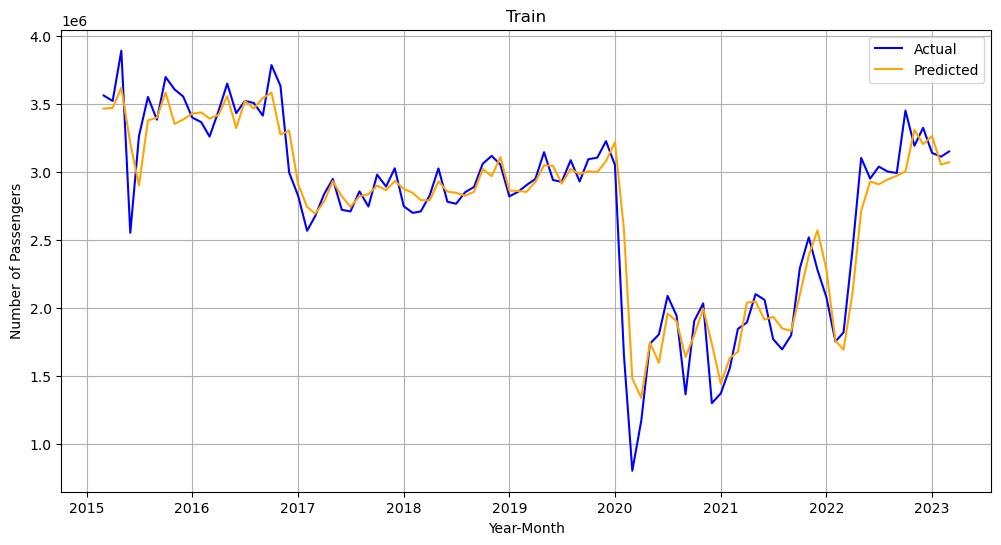

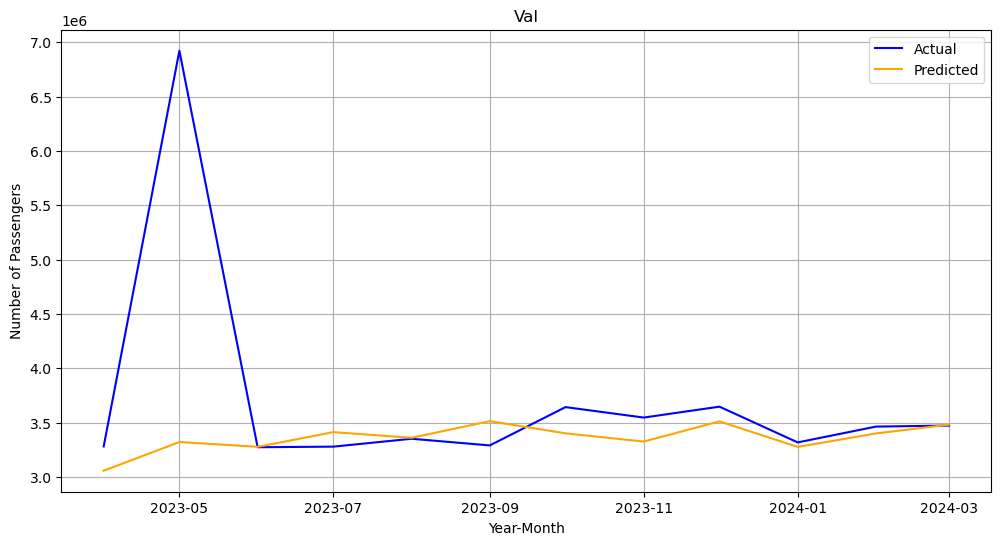

In [5]:
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240615.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# RandomForest 모델 평가
best_rf_model, rf_results = model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
print("The best hyperparameters : ", "\n")
print(rf_results['best_hyperparams'])

print('Random Forest(Train):')
print(f"R-squared: {rf_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {rf_results['train_metrics']['mae']:.2f}")
print(f"MSE: {rf_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {rf_results['train_metrics']['mape']:.2f}%")
print()
print('Random Forest(Val):')
print(f"R-squared: {rf_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {rf_results['val_metrics']['mae']:.2f}")
print(f"MSE: {rf_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {rf_results['val_metrics']['mape']:.2f}%")

Y_train_pred_rf = best_rf_model.predict(X_train_scaled)
Y_val_pred_rf = best_rf_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_rf, Y_val, Y_val_pred_rf)

# XGBoost

100%|███████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78trial/s, best loss: 400625.7083333333]
The best hyperparameters :  

{'colsample_bytree': 0.7400814816841502, 'gamma': 0.19989639253895738, 'learning_rate': 0.1556485686774296, 'max_depth': 14.0, 'n_estimators': 100.0, 'reg_alpha': 0.4530533372357757, 'reg_lambda': 0.8562574731735484, 'subsample': 0.7141223999337547}
XGBoost(Train):
R-squared: 1.00
MAE: 541.87
MSE: 969184.44
MAPE: 0.03%

XGBoost(Val):
R-squared: -0.12
MAE: 400625.71
MSE: 1069473355145.43
MAPE: 7.41%


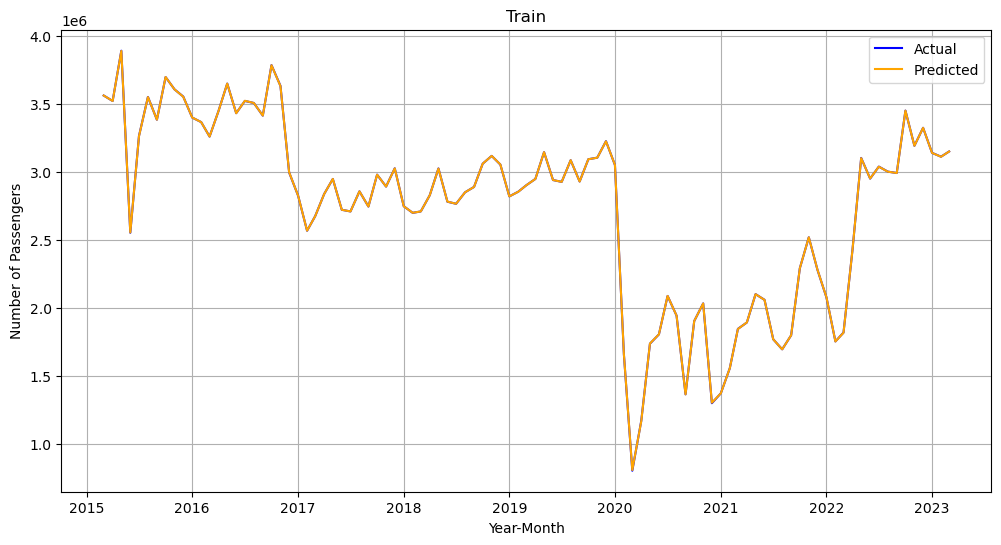

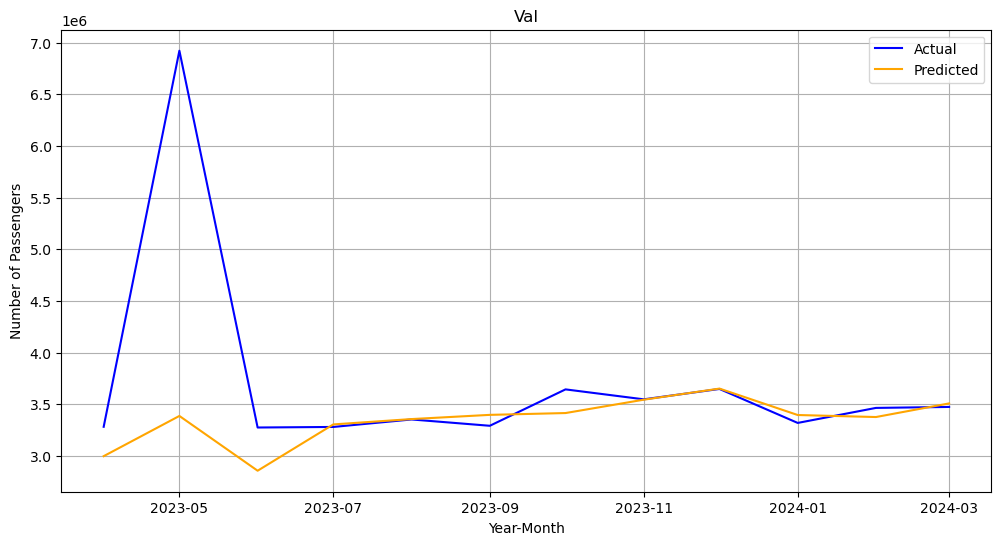

In [6]:
# XGBoost 모델 평가
best_xgb_model, xgb_results = model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
print("The best hyperparameters : ", "\n")
print(xgb_results['best_hyperparams'])

print('XGBoost(Train):')
print(f"R-squared: {xgb_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {xgb_results['train_metrics']['mae']:.2f}")
print(f"MSE: {xgb_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {xgb_results['train_metrics']['mape']:.2f}%")
print()
print('XGBoost(Val):')
print(f"R-squared: {xgb_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {xgb_results['val_metrics']['mae']:.2f}")
print(f"MSE: {xgb_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {xgb_results['val_metrics']['mape']:.2f}%")

Y_train_pred_xgb = best_xgb_model.predict(X_train_scaled)
Y_val_pred_xgb = best_xgb_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_xgb, Y_val, Y_val_pred_xgb)
#{'colsample_bytree': 0.8922607113389976, 'gamma': 0.29202225637784096, 'learning_rate': 0.10486928608249282, 'max_depth': 6.0, 'n_estimators': 280.0, 'reg_alpha': 0.9413775711280722, 'reg_lambda': 0.8990091066271554, 'subsample': 0.8712113355918811}

# LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 6
[LightGBM] [Info] Start training from score 2752700.144330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

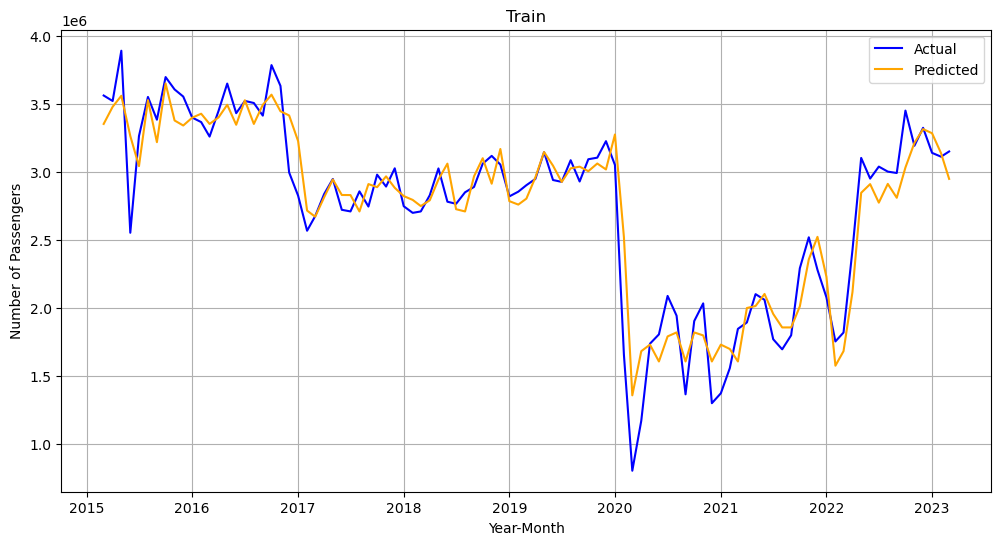

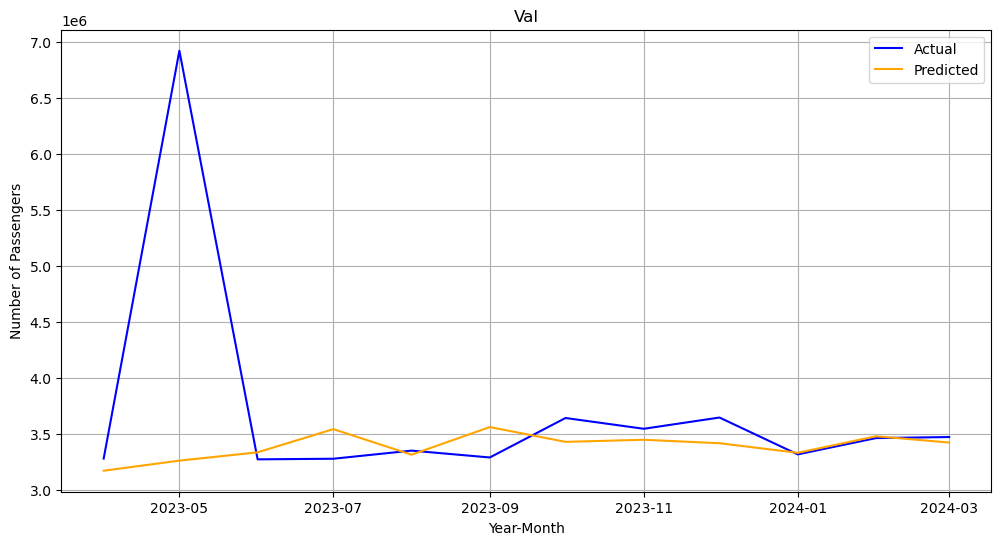

In [7]:
best_lgb_model, lgb_results = model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val)
print("LightGBM(Train):")
print(f"R-squared: {lgb_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {lgb_results['train_metrics']['mae']:.2f}")
print(f"MSE: {lgb_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {lgb_results['train_metrics']['mape']:.2f}%")
print()
print("LightGBM(Val):")
print(f"R-squared: {lgb_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {lgb_results['val_metrics']['mae']:.2f}")
print(f"MSE: {lgb_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {lgb_results['val_metrics']['mape']:.2f}%")

Y_train_pred_lgb = best_lgb_model.predict(X_train_scaled)
Y_val_pred_lgb = best_lgb_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_lgb, Y_val, Y_val_pred_lgb)


# LSTM

Epoch 1/100
2/2 - 12s - 6s/step - loss: 0.4312 - val_loss: 0.0730
Epoch 2/100
2/2 - 1s - 678ms/step - loss: 0.3500 - val_loss: 0.0722
Epoch 3/100
2/2 - 0s - 67ms/step - loss: 0.2619 - val_loss: 0.1009
Epoch 4/100
2/2 - 0s - 69ms/step - loss: 0.1618 - val_loss: 0.2128
Epoch 5/100
2/2 - 0s - 115ms/step - loss: 0.0781 - val_loss: 0.5357
Epoch 6/100
2/2 - 0s - 73ms/step - loss: 0.0783 - val_loss: 0.7799
Epoch 7/100
2/2 - 0s - 66ms/step - loss: 0.1157 - val_loss: 0.6023
Epoch 8/100
2/2 - 0s - 56ms/step - loss: 0.0747 - val_loss: 0.3987
Epoch 9/100
2/2 - 0s - 80ms/step - loss: 0.0609 - val_loss: 0.2811
Epoch 10/100
2/2 - 0s - 65ms/step - loss: 0.0660 - val_loss: 0.2321
Epoch 11/100
2/2 - 0s - 63ms/step - loss: 0.0728 - val_loss: 0.2255
Epoch 12/100
2/2 - 0s - 65ms/step - loss: 0.0717 - val_loss: 0.2470
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM(Train):
R-squared: -4.89
MAE: 1496411.36
MSE: 2646736977837.80
MAPE: 51.29%

LSTM(Val):
R-squared: -0.00
MAE: 

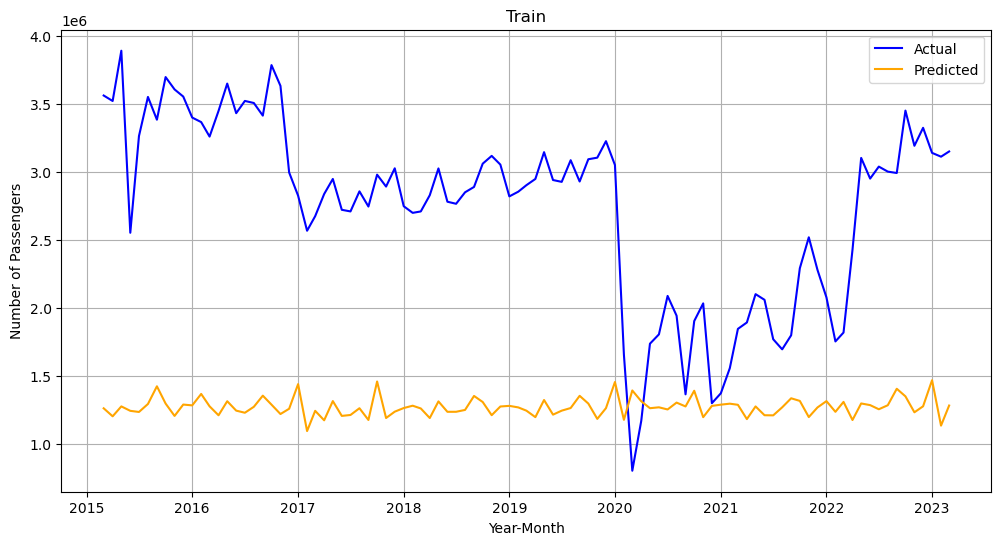

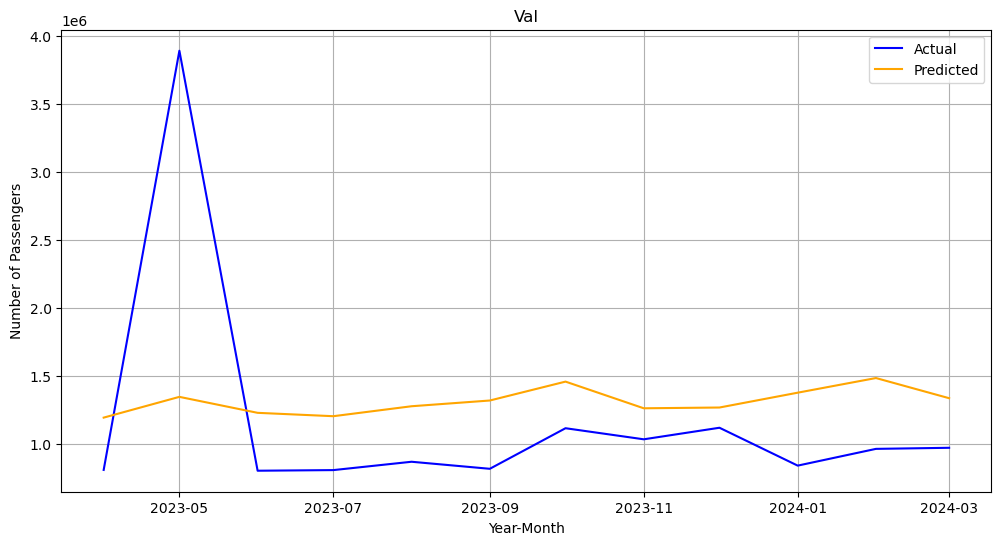

In [8]:
def preprocess_lstm(X, Y):
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1))

    X_reshaped = X_scaled.reshape((X.shape[0], X.shape[1], 1))
    Y_reshaped = Y_scaled.reshape((Y.shape[0], 1))
    
    return X_reshaped, Y_reshaped, scaler_X, scaler_Y

def create_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_lstm(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
    input_shape = (X_train.shape[1], X_train.shape[2])
    lstm_model = create_lstm(input_shape)

    history = lstm_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                             validation_data=(X_val, Y_val), verbose=2, 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    Y_train_pred = lstm_model.predict(X_train)
    Y_val_pred = lstm_model.predict(X_val)

    return lstm_model, Y_train_pred, Y_val_pred, history

def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240615.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# 전처리
X_train_lstm, Y_train_lstm, scaler_X, scaler_Y = preprocess_lstm(X_train_scaled, Y_train)
X_val_lstm, Y_val_lstm, _, _ = preprocess_lstm(X_val_scaled, Y_val)

# LSTM 모델 평가
best_lstm_model, Y_train_pred_lstm, Y_val_pred_lstm, history = model_lstm(X_train_lstm, Y_train_lstm, X_val_lstm, Y_val_lstm, epochs=100, batch_size=64)

# 역변환
Y_train_pred_lstm = scaler_Y.inverse_transform(Y_train_pred_lstm)
Y_val_pred_lstm = scaler_Y.inverse_transform(Y_val_pred_lstm)
Y_train_lstm = scaler_Y.inverse_transform(Y_train_lstm)
Y_val_lstm = scaler_Y.inverse_transform(Y_val_lstm)

# 지표
train_r_squared = r2_score(Y_train_lstm, Y_train_pred_lstm)
train_mae = mean_absolute_error(Y_train_lstm, Y_train_pred_lstm)
train_mse = mean_squared_error(Y_train_lstm, Y_train_pred_lstm)
train_mape = np.mean(np.abs((Y_train_lstm - Y_train_pred_lstm) / Y_train_lstm)) * 100

val_r_squared = r2_score(Y_val_lstm, Y_val_pred_lstm)
val_mae = mean_absolute_error(Y_val_lstm, Y_val_pred_lstm)
val_mse = mean_squared_error(Y_val_lstm, Y_val_pred_lstm)
val_mape = np.mean(np.abs((Y_val_lstm - Y_val_pred_lstm) / Y_val_lstm)) * 100

results = {
    'train_metrics': {
        'r_squared': train_r_squared,
        'mae': train_mae,
        'mse': train_mse,
        'mape': train_mape
    },
    'val_metrics': {
        'r_squared': val_r_squared,
        'mae': val_mae,
        'mse': val_mse,
        'mape': val_mape
    }
}

print('LSTM(Train):')
print(f"R-squared: {results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {results['train_metrics']['mae']:.2f}")
print(f"MSE: {results['train_metrics']['mse']:.2f}")
print(f"MAPE: {results['train_metrics']['mape']:.2f}%")
print()
print('LSTM(Val):')
print(f"R-squared: {results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {results['val_metrics']['mae']:.2f}")
print(f"MSE: {results['val_metrics']['mse']:.2f}")
print(f"MAPE: {results['val_metrics']['mape']:.2f}%")

plot_results(train_data, val_data, Y_train_lstm, Y_train_pred_lstm, Y_val_lstm, Y_val_pred_lstm)

# CNN

Epoch 1/100
2/2 - 4s - 2s/step - loss: 0.3676 - val_loss: 0.0743
Epoch 2/100
2/2 - 0s - 176ms/step - loss: 0.2432 - val_loss: 0.1058
Epoch 3/100
2/2 - 0s - 61ms/step - loss: 0.1344 - val_loss: 0.1760
Epoch 4/100
2/2 - 0s - 48ms/step - loss: 0.0780 - val_loss: 0.2897
Epoch 5/100
2/2 - 0s - 49ms/step - loss: 0.0615 - val_loss: 0.4151
Epoch 6/100
2/2 - 0s - 50ms/step - loss: 0.0738 - val_loss: 0.4755
Epoch 7/100
2/2 - 0s - 57ms/step - loss: 0.0918 - val_loss: 0.4446
Epoch 8/100
2/2 - 0s - 58ms/step - loss: 0.0784 - val_loss: 0.3757
Epoch 9/100
2/2 - 0s - 48ms/step - loss: 0.0527 - val_loss: 0.3099
Epoch 10/100
2/2 - 0s - 60ms/step - loss: 0.0561 - val_loss: 0.2540
Epoch 11/100
2/2 - 0s - 52ms/step - loss: 0.0436 - val_loss: 0.2161
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
CNN(Train):
R-squared: -4.46
MAE: 1440976.86
MSE: 2455344125169.56
MAPE: 49.39%

CNN(Val):
R-squared: -0.03
MAE: 572033.40
MSE: 710236230672.23
MAPE: 46.74%


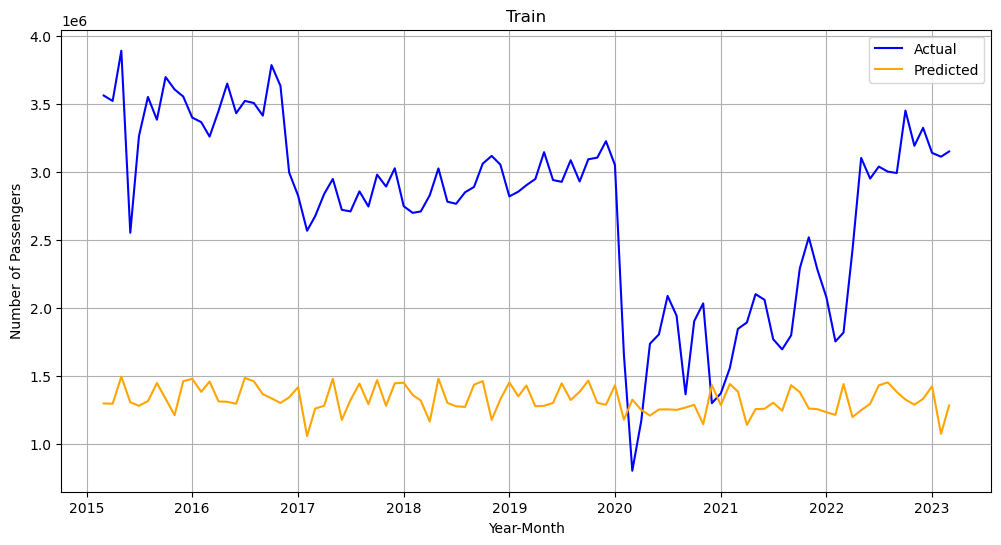

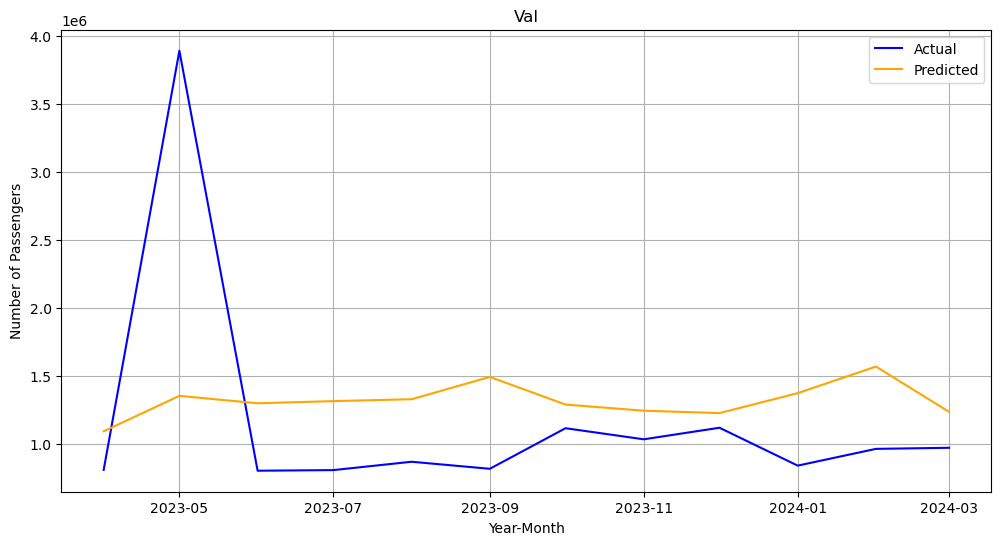

In [9]:
def preprocess_cnn(X, Y):
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1))

    X_reshaped = X_scaled.reshape((X.shape[0], X.shape[1], 1))
    Y_reshaped = Y_scaled.reshape((Y.shape[0], 1))
    
    return X_reshaped, Y_reshaped, scaler_X, scaler_Y

def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_cnn(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
    input_shape = (X_train.shape[1], X_train.shape[2])
    cnn_model = create_cnn(input_shape)

    history = cnn_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                            validation_data=(X_val, Y_val), verbose=2, 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    Y_train_pred = cnn_model.predict(X_train)
    Y_val_pred = cnn_model.predict(X_val)

    return cnn_model, Y_train_pred, Y_val_pred, history

def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240615.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# 전처리 
X_train_cnn, Y_train_cnn, scaler_X, scaler_Y = preprocess_cnn(X_train_scaled, Y_train)
X_val_cnn, Y_val_cnn, _, _ = preprocess_cnn(X_val_scaled, Y_val)

# 평가
best_cnn_model, Y_train_pred_cnn, Y_val_pred_cnn, history_cnn = model_cnn(X_train_cnn, Y_train_cnn, X_val_cnn, Y_val_cnn, epochs=100, batch_size=64)

# 역변환 
Y_train_pred_cnn = scaler_Y.inverse_transform(Y_train_pred_cnn)
Y_val_pred_cnn = scaler_Y.inverse_transform(Y_val_pred_cnn)
Y_train_cnn = scaler_Y.inverse_transform(Y_train_cnn)
Y_val_cnn = scaler_Y.inverse_transform(Y_val_cnn)

# 지표
train_r_squared_cnn = r2_score(Y_train_cnn, Y_train_pred_cnn)
train_mae_cnn = mean_absolute_error(Y_train_cnn, Y_train_pred_cnn)
train_mse_cnn = mean_squared_error(Y_train_cnn, Y_train_pred_cnn)
train_mape_cnn = np.mean(np.abs((Y_train_cnn - Y_train_pred_cnn) / Y_train_cnn)) * 100

val_r_squared_cnn = r2_score(Y_val_cnn, Y_val_pred_cnn)
val_mae_cnn = mean_absolute_error(Y_val_cnn, Y_val_pred_cnn)
val_mse_cnn = mean_squared_error(Y_val_cnn, Y_val_pred_cnn)
val_mape_cnn = np.mean(np.abs((Y_val_cnn - Y_val_pred_cnn) / Y_val_cnn)) * 100

results_cnn = {
    'train_metrics': {
        'r_squared': train_r_squared_cnn,
        'mae': train_mae_cnn,
        'mse': train_mse_cnn,
        'mape': train_mape_cnn
    },
    'val_metrics': {
        'r_squared': val_r_squared_cnn,
        'mae': val_mae_cnn,
        'mse': val_mse_cnn,
        'mape': val_mape_cnn
    }
}


print('CNN(Train):')
print(f"R-squared: {results_cnn['train_metrics']['r_squared']:.2f}")
print(f"MAE: {results_cnn['train_metrics']['mae']:.2f}")
print(f"MSE: {results_cnn['train_metrics']['mse']:.2f}")
print(f"MAPE: {results_cnn['train_metrics']['mape']:.2f}%")
print()
print('CNN(Val):')
print(f"R-squared: {results_cnn['val_metrics']['r_squared']:.2f}")
print(f"MAE: {results_cnn['val_metrics']['mae']:.2f}")
print(f"MSE: {results_cnn['val_metrics']['mse']:.2f}")
print(f"MAPE: {results_cnn['val_metrics']['mape']:.2f}%")

plot_results(train_data, val_data, Y_train_cnn, Y_train_pred_cnn, Y_val_cnn, Y_val_pred_cnn)


# RNN

Epoch 1/100
2/2 - 5s - 2s/step - loss: 0.4310 - val_loss: 0.0785
Epoch 2/100
2/2 - 0s - 76ms/step - loss: 0.3433 - val_loss: 0.0747
Epoch 3/100
2/2 - 0s - 44ms/step - loss: 0.2803 - val_loss: 0.0747
Epoch 4/100
2/2 - 0s - 50ms/step - loss: 0.2152 - val_loss: 0.0795
Epoch 5/100
2/2 - 0s - 52ms/step - loss: 0.1734 - val_loss: 0.0928
Epoch 6/100
2/2 - 0s - 44ms/step - loss: 0.1243 - val_loss: 0.1207
Epoch 7/100
2/2 - 0s - 47ms/step - loss: 0.0714 - val_loss: 0.1708
Epoch 8/100
2/2 - 0s - 49ms/step - loss: 0.0570 - val_loss: 0.2450
Epoch 9/100
2/2 - 0s - 41ms/step - loss: 0.0678 - val_loss: 0.3055
Epoch 10/100
2/2 - 0s - 47ms/step - loss: 0.0542 - val_loss: 0.3142
Epoch 11/100
2/2 - 0s - 47ms/step - loss: 0.0693 - val_loss: 0.2860
Epoch 12/100
2/2 - 0s - 42ms/step - loss: 0.0569 - val_loss: 0.2416
Epoch 13/100
2/2 - 0s - 44ms/step - loss: 0.0577 - val_loss: 0.2033
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict

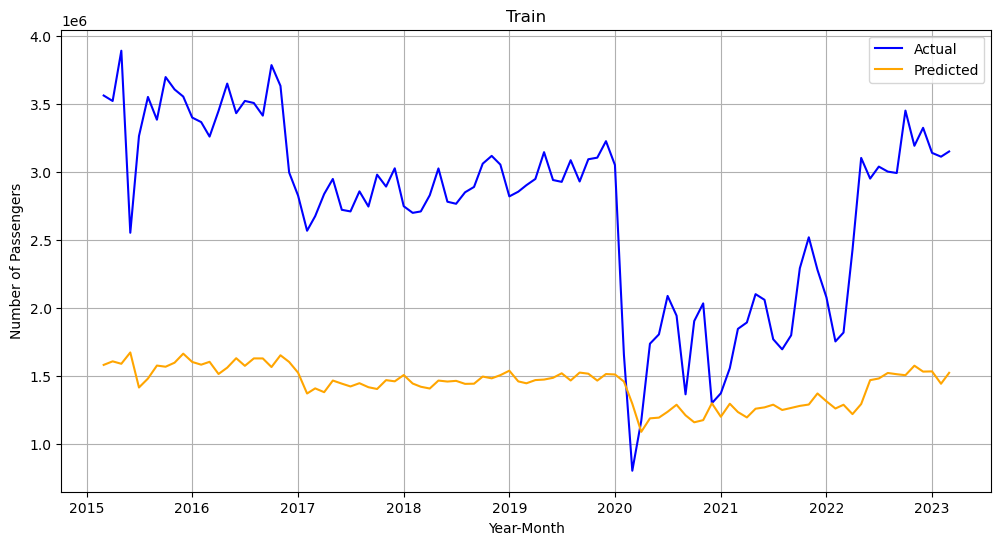

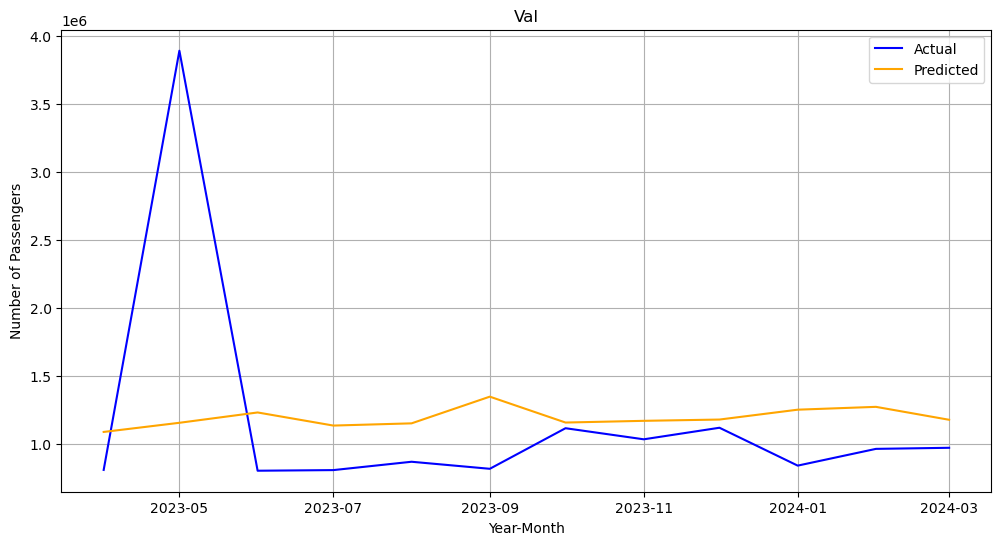

In [11]:
def preprocess_rnn(X, Y):
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1))

    X_reshaped = X_scaled.reshape((X.shape[0], X.shape[1], 1))
    Y_reshaped = Y_scaled.reshape((Y.shape[0], 1))
    
    return X_reshaped, Y_reshaped, scaler_X, scaler_Y

def create_rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(64, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_rnn(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
    input_shape = (X_train.shape[1], X_train.shape[2])
    rnn_model = create_rnn(input_shape)

    history = rnn_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                            validation_data=(X_val, Y_val), verbose=2, 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    Y_train_pred = rnn_model.predict(X_train)
    Y_val_pred = rnn_model.predict(X_val)

    return rnn_model, Y_train_pred, Y_val_pred, history

def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240615.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

X_train_rnn, Y_train_rnn, scaler_X, scaler_Y = preprocess_rnn(X_train_scaled, Y_train)
X_val_rnn, Y_val_rnn, _, _ = preprocess_rnn(X_val_scaled, Y_val)


best_rnn_model, Y_train_pred_rnn, Y_val_pred_rnn, history_rnn = model_rnn(X_train_rnn, Y_train_rnn, X_val_rnn, Y_val_rnn, epochs=100, batch_size=64)

# 역변환 
Y_train_pred_rnn = scaler_Y.inverse_transform(Y_train_pred_rnn)
Y_val_pred_rnn = scaler_Y.inverse_transform(Y_val_pred_rnn)
Y_train_rnn = scaler_Y.inverse_transform(Y_train_rnn)
Y_val_rnn = scaler_Y.inverse_transform(Y_val_rnn)


train_r_squared_rnn = r2_score(Y_train_rnn, Y_train_pred_rnn)
train_mae_rnn = mean_absolute_error(Y_train_rnn, Y_train_pred_rnn)
train_mse_rnn = mean_squared_error(Y_train_rnn, Y_train_pred_rnn)
train_mape_rnn = np.mean(np.abs((Y_train_rnn - Y_train_pred_rnn) / Y_train_rnn)) * 100

val_r_squared_rnn = r2_score(Y_val_rnn, Y_val_pred_rnn)
val_mae_rnn = mean_absolute_error(Y_val_rnn, Y_val_pred_rnn)
val_mse_rnn = mean_squared_error(Y_val_rnn, Y_val_pred_rnn)
val_mape_rnn = np.mean(np.abs((Y_val_rnn - Y_val_pred_rnn) / Y_val_rnn)) * 100

results_rnn = {
    'train_metrics': {
        'r_squared': train_r_squared_rnn,
        'mae': train_mae_rnn,
        'mse': train_mse_rnn,
        'mape': train_mape_rnn
    },
    'val_metrics': {
        'r_squared': val_r_squared_rnn,
        'mae': val_mae_rnn,
        'mse': val_mse_rnn,
        'mape': val_mape_rnn
    }
}


print('RNN(Train):')
print(f"R-squared: {results_rnn['train_metrics']['r_squared']:.2f}")
print(f"MAE: {results_rnn['train_metrics']['mae']:.2f}")
print(f"MSE: {results_rnn['train_metrics']['mse']:.2f}")
print(f"MAPE: {results_rnn['train_metrics']['mape']:.2f}%")
print()
print('RNN(Val):')
print(f"R-squared: {results_rnn['val_metrics']['r_squared']:.2f}")
print(f"MAE: {results_rnn['val_metrics']['mae']:.2f}")
print(f"MSE: {results_rnn['val_metrics']['mse']:.2f}")
print(f"MAPE: {results_rnn['val_metrics']['mape']:.2f}%")

plot_results(train_data, val_data, Y_train_rnn, Y_train_pred_rnn, Y_val_rnn, Y_val_pred_rnn)